# Day 2 Exercises (NumPy + Matplotlib)

## Part 1: Basic NumPy Operations
a) Generate an array of numbers 0-24. Reshape to a 5x5 matrix.

b) Extract the diagonal of this matrix.

c) Multiply the matrix by an identity matrix of the same shape. Confirm that it is identical to the original.

Hint: Use `np.all` command to confirm all equal. 

d) Join the matrix with itself and return a new matrix with shape (2,5,5).

e) Compute the mean of the concatenated matrix along the first axis. Confirm its equal to the original matrix.

f) Return the indices of the matrix where the elements are greater than 15.

g) Using `np.where`, set all elements of the matrix greater than 15 to 1, else 0.


h) Set all elements of the matrix greater than 15 to 2, less than 5 to 1, else 0.

Hint: `np.where` can be passed as an input to `np.where`.

i) Return the lower triangle of the original matrix.

j) Define a demean function.

k) Apply the demean function across each row of the matrix.

## Part 2: Spike Detection

In the following exercises, you will be manipulating, analyzing, and visualizing preprocessed extracellular electrophysiological data. Specifically, you will be working with a 10s recording taken from a [nerve in the abdomen of a crayfish](https://www.science.smith.edu/departments/neurosci/courses/bio330/labs/L7pix/hookelectr.jpg). Action potentials are visually apparent throughout the entire recording. 

This exercise will focus primarily on the problem of **spike detection**. Before diving in, we recommend you take a few moments to skim [Rey et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0361923015000684), which will help frame the problem and describe the steps involved. Specifically, we recommend reading up to and including Section 2.2, *Spike Detection*.

First, we load the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load data.
npz = np.load('spikes.npz')   # spikes.npz is a compressed NumPy object containing the data.
data = npz['data'] * 1e6      # data is the recording itself, which we convert to microvolts.
times = npz['times']          # times contains the timestamp for each sample of recording.

a) First, check the metadata of *data* and *times*. How many samples (elements) are in *data*? How long (in seconds) is the recording? 

In [5]:
print(data.shape)
min(times)
max(times)

(100001,)


10.0

b) Plot the entire raw recording with time (in seconds) on the x-axis and voltage (in microvolts) on the y-axis. 

In this simple circuit, different types of spikes can be identified according to their amplitudes. Do multiple types of spikes appear to be present?

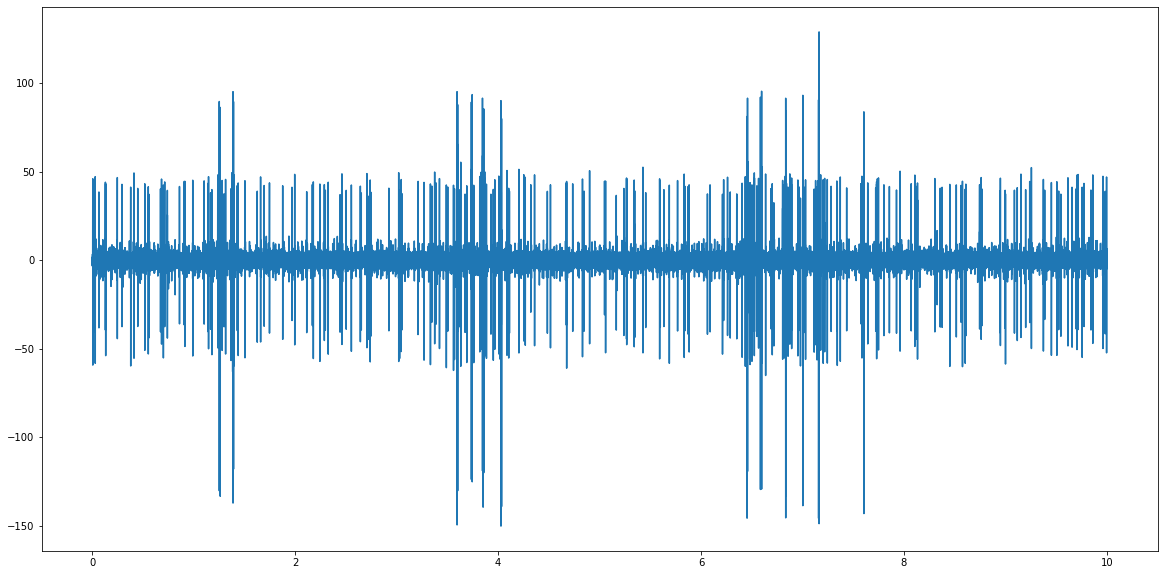

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(times,data)

c) Try "zooming in" on different sections of recording. That is, try plotting smaller segments (0.5s, 1.0s) of recordings. How would you restrict your graph to a smaller slice of data? (Hint: this can be done without changing the inputs to `ax.plot`)

[(1, 2)]

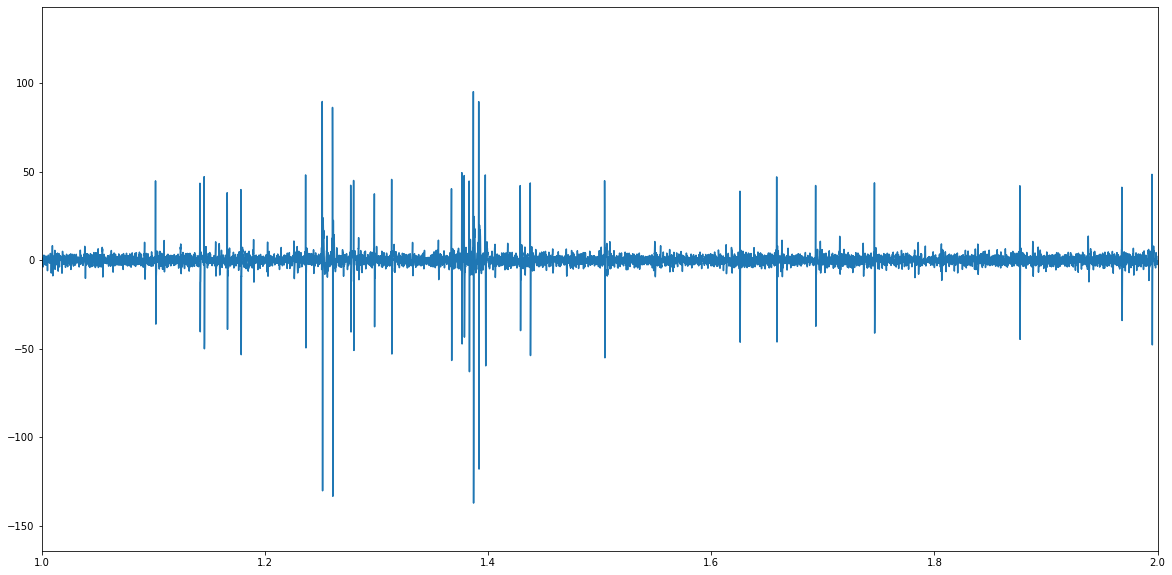

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(times,data)
ax.set (xlim=(1,2))

d) [Rey et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0361923015000684) suggest a simple spike detection technique via data-driven amplitude thresholding. Specifically, they propose using an amplitude threshold defined as multiple of an estimate of the standard deviation of the noise:

$$ \text{threshold} = k \cdot \hat{\sigma}_n $$

where $k$ is a constant typically between 3-5; and $\hat{\sigma}_n$ is an estimate of the standard deviation of the noise, defined as:

$$ \hat{\sigma}_n = \frac{\text{median} \left( |X| \right)}{0.6745} $$ 

where $|X|$ is the absolute value of the raw data.

Write a function that returns the amplitude threshold as defined above. The function should accept as arguments the raw data, $X$, and the constant, $k$. 

In [17]:
def thresh_spike(X,k=3):
    """calculate spike threshold for given data set 
    Parameters
    -----
    X = array_like,
    k = constant between 3 and 5 
    """
    abs_X = np.abs(X)
    med_X = np.median(abs_X)
    std_X = med_X / 0.6745 
    thresh_X = std_X * k 
    return thresh_X

In [18]:
thresh_spike(data)

6.806601488164624

e) Using your function, compute different amplitude thresholds for different values of $k$. Overlay each threshold as a horizonal line on a plot of the raw recording. (Hint: google a horizontal line function in Matplotlib.)

For different threshold levels (values of $k$), how sensitive does the threshold seem to be? In other words, how good is your threshold at detecting "true" spikes from "noise"? (To assess this, it may be helpful to zoom in on specific segments of the data.)

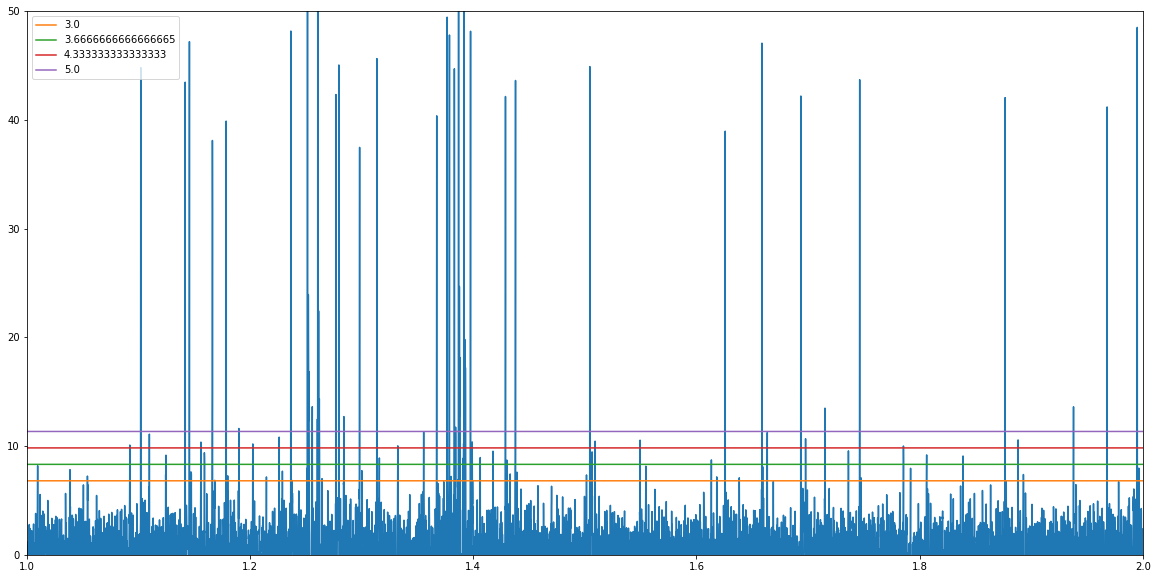

In [29]:
thresholds = np.linspace(3,5,4)

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(times,data)
ax.set (xlim=(1,2))

for i,k in enumerate(thresholds): 
    cur_thresh = thresh_spike(data, k)
    ax.plot(times,np.ones(len(times))*cur_thresh, label = k) 
    
ax.set(xlim=(1,2), ylim=(0,50)) 
ax.legend(loc=2)

f) Next we need a function that can detect segments of the raw signal that exceed the threshold. This ultimately becomes a clustering problem (i.e. identifying "islands" of signal rising above an "ocean of noise"). 

Though this is definitely doable with core NumPy, the SciPy library has built-in functions specifically written for these purposes. Because these functions are beyond the scope of the bootcamp, we have provided a peak finding function for you. The function relies on the `measurements` tools from scipy.ndimage. For a tutorial, see [here](https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/).

The function, `peak_finder`, accepts a raw data trace and a threshold. It then finds all clusters of samples above the given threshold and returns:
- the indices (positions in the array) corresponding to the peak of each cluster
- the magnitude of the signal at each peak

In [30]:
def peak_finder(X, thresh):
    """Simple peak finding algorithm.
    
    Parameters
    ----------
    X : array_like, shape (n_times,)
        Raw data trace.
    thresh : float
        Amplitude threshold.
        
    Returns
    -------
    peak_loc : array_like, shape (n_clusters,)
        Index of peak amplitudes.
    peak_mag : array_like, shape (n_clusters,)
        Magnitude of peak amplitudes.
    """
    import numpy as np
    from scipy.ndimage import measurements
    
    ## Error-catching.
    assert X.ndim == 1
    
    ## Identify clusters.
    clusters, ix = measurements.label(X > thresh)
    
    ## Identify index of peak amplitudes. 
    peak_loc = np.concatenate(measurements.maximum_position(X, labels=clusters, index=np.arange(ix)+1))
    
    ## Identify magnitude of peak amplitudes.
    peak_mag = measurements.maximum(X, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

g) Apply the peak detection algorithm to the raw data using a threshold of your choice (recommendation: $k=6$). How many spikes are detected? If you adjust the threshold up or down, how does this change the number of spikes detected?

In [32]:
cur_thresh = thresh_spike(data, 6)
locs, mags = peak_finder(data, cur_thresh)
locs.shape

(322,)

h) Now for a challenge. First, plot the first second of the recording. Next, using a scatterplot (or any other method you can think of), plot the peak for each detected spike. In other words, each point in the scatter plot should be (time of spike (s), amplitude of spike (uV)). 

(Hint: *peak_loc* gives you the index of each spike in the data array. Remember that *data* and *times* have the same number of elements.)

[(-150.25874310256944, 129.00222228624014), (0, 1)]

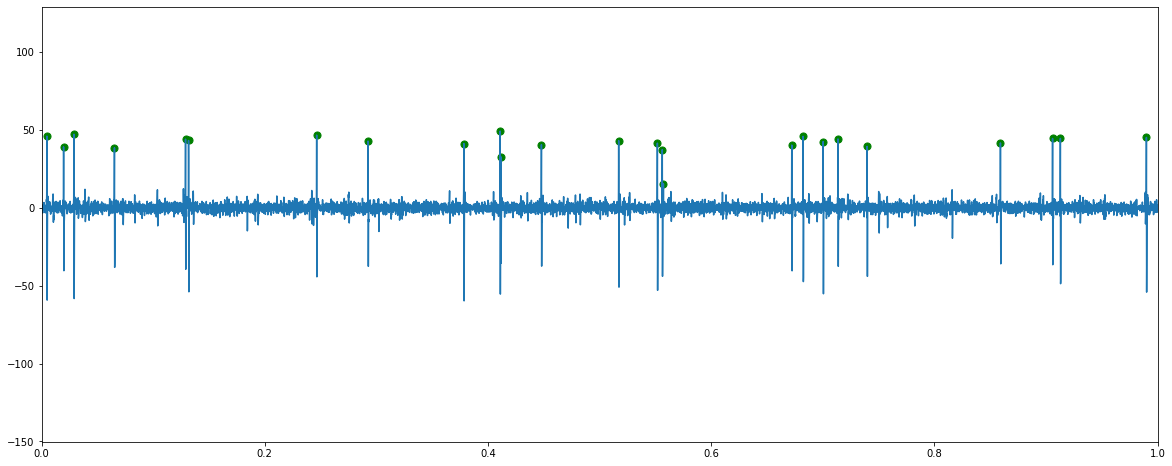

In [51]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.plot(times,data)

ax.scatter(times[locs], mags, s=50, c='green')

ax.set(xlim=(0,1), ylim=(data.min(), data.max()))

i) Remake the plot above using different thresholds. For different threshold levels (values of $k$), how sensitive does the threshold seem to be? In other words, how good is your threshold at detecting "true" spikes from "noise"? (To assess this, it may be helpful to zoom in on different segments of the data.)

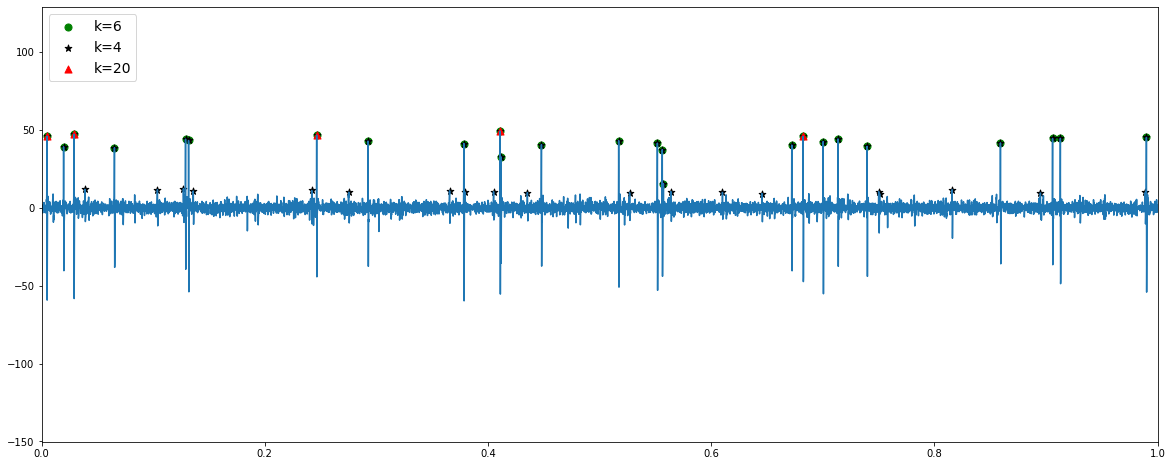

In [60]:
cur_thresh2 = thresh_spike(data, 4)
cur_thresh3 = thresh_spike(data, 20)
locs2, mags2 = peak_finder(data, cur_thresh2)
locs3, mags3 = peak_finder(data, cur_thresh3)

fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.plot(times,data)

ax.scatter(times[locs], mags, s=50, c='green', label = 'k=6')
ax.scatter(times[locs2], mags2, s=50, c='k', marker='*', label = 'k=4')
ax.scatter(times[locs3], mags3, s=50, c='red', marker='^', label = 'k=20')

ax.set(xlim=(0,1), ylim=(data.min(), data.max()))
ax.legend(loc=2, fontsize = 14)

j) Based on your exploration above, choose a threshold value. You will use this threshold value for the remainder of this exercise. 

Once you've selected your threshold, use `peak_finder` again to detect spikes in the recording. Then plot a histogram of the spike amplitudes it detects (try bins of 0-150 in increments of 5 uV). 

How many spikes are detected? Based on their amplitudes, how many types of spikes do there appear to be?

hist_bins [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145]
number of spikes 322


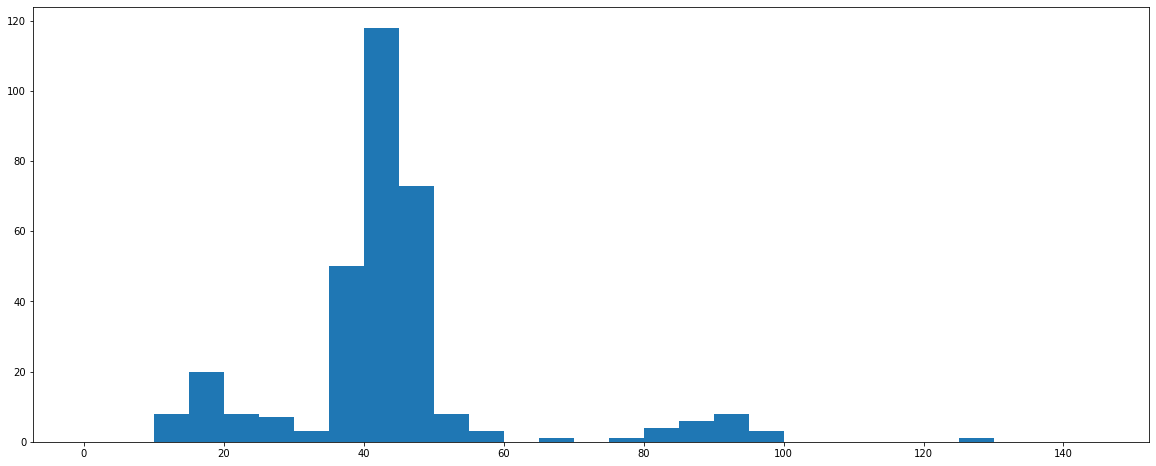

In [71]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
hist_bins = np.arange(0,150,5)
plt.hist(mags, bins = hist_bins)
print('hist_bins',hist_bins)
print('number of spikes', mags.size)

k) Based on the plot above, define a set of boundaries that divides the spikes into different clusters. Find a NumPy function that assigns an each spike amplitude to a category based on your defined boundaries. (Hint: there are at least three.) Store the category labels in a new variable, *labels*. 

After binning, how many spikes are in each cluster?

In [86]:
divs = [32.5, 60, 100]
ind_1 = (mags < divs[0])*1
ind_2 = ((mags > divs[0]) & (mags < divs[1]))*2
ind_3 = ((mags > divs[1]) & (mags < divs[2]))*3

labels = ind_1 + ind_2 + ind_3
#print(labels)

cluster_1 = mags[np.where(labels ==1)]
cluster_2 = mags[np.where(labels ==2)]
cluster_3 = mags[np.where(labels ==3)]

print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)

(44,)
(254,)
(23,)


m) **CHALLENGE**: Action potentials last roughly 1-2 milliseconds. With this in mind, extract a 3 ms window around each detected spike; that is, extract 1.5 ms of samples on either side of the detected peak. Store each epoch in a separate list according to its cluster. (Hint: The data were recorded at 10 KHz meaning there are 10 samples per millisecond.)

This is a challenging exercise that can be solved in many different ways. Before jumping in, take a few minutes to brainstorm pseudocode with your team. That is, write out in words each step you need to take to solve this problem.

In [94]:
print(labels.shape)
print(locs.shape)

windows = []
time_offset = int(1.5 * 10)

for i,loc in enumerate(locs): 
    windows.append(data[loc-time_offset:loc+time_offset])
    #return windows

windows_array = np.array(windows)
windows_array.shape

win_cluster_1 = windows_array[np.where(labels ==1)]
win_cluster_2 = windows_array[np.where(labels ==2)]
win_cluster_3 = windows_array[np.where(labels ==3)]

print(win_cluster_1.shape)
print(win_cluster_2.shape)
print(win_cluster_3.shape)

(322,)
(322,)
(44, 30)
(254, 30)
(23, 30)


n) Compute the average spike waveform for each cluster. Then, plot each average waveform in a single plot. Add a legend denoting the spike cluster.

[Text(0, 0.5, 'signal(uV)'),
 Text(0.5, 0, 'time(ms)'),
 Text(0.5, 1.0, 'Clustered Average Spike Waveforms')]

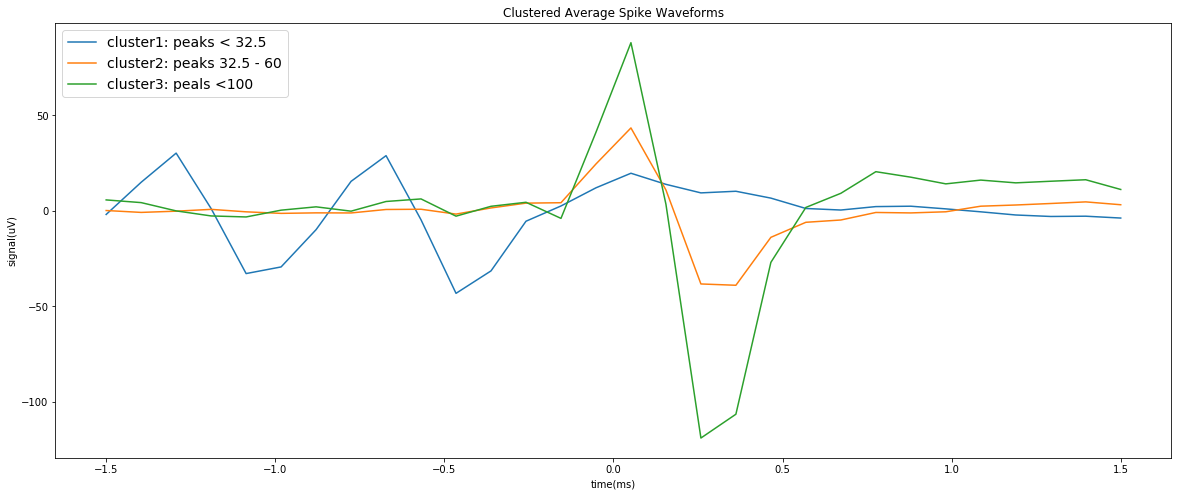

In [102]:
mean_1 = np.mean(win_cluster_1, axis=0)
mean_2 = np.mean(win_cluster_2, axis=0)
mean_3 = np.mean(win_cluster_3, axis=0)

fig, ax = plt.subplots(1,1, figsize=(20,8))
time_x = np.linspace(-15,15,30) / 10

ax.plot(time_x,mean_1, label = "cluster1: peaks < 32.5")
ax.plot(time_x,mean_2, label = "cluster2: peaks 32.5 - 60")
ax.plot(time_x,mean_3, label = "cluster3: peals <100")
ax.legend(loc=2, fontsize=14)
ax.set(xlabel="time(ms)", ylabel="signal(uV)", title ="Clustered Average Spike Waveforms")

## Bonus: Two-Photon Recordings

In this set of exercises, you will manipulate, analyze, and visualize preprocssed two-photon calcium imaging data collected from a larval zebrafish. A schematic of the experimental setup is below. The larval zebrafish was fixed in place and presented a series of rotating light-dark bands. The stimuli moved either in clockwise rotation (red) or counterclockwise rotation (blue). The green box indicates the section of the zebrafish imaged.

<img src="larval_zebrafish.png">

Next we load in the data. Note, the data is three-dimensional, *[time, x-dim, y-dim]*.

In [ ]:
import numpy as np

## Load data.
npz = np.load('calcium.npz')
data = npz['data']
times = npz['times']
cw = npz['cw']
ccw = npz['ccw']

print(data.shape)

a) Using `plt.imshow`, plot the total luminance (i.e. sum across all timepoints within each pixel).

b) Using `np.percentile`, create different masks of the data by setting to zero pixels that fall beneath some percentile of brightness. How well can you isolate individual neurons?

c) To get a better understanding of the timing of the experiment, plot the clockwise (CW) and counterclockwise (CCW) stimulus timeseries. Add a legend to differentiate the two.

d) Next, we will try to isolate neurons selective to clockwise rotation of the visual stimulus. To do so, matrix multiply (i.e. take the inner product of) the clockwise stimulus timeseries and the 3d data matrix. Plot the resulting mask with `plt.imshow`. 

e) Repeat the step above but now for the counterclockwise stimulus timeseries. Are a different set of neurons now more prominent?

f) Extract the timeseries of the 99th percentile brightest pixels from the thresholded maps in (d) and (e). Average the pixel timeseries within each condition (i.e. CW, CCW). Finally, plot the two separate averaged timeseries. Do they resemble the stimulus timeseries plots in (c)?